# Impact of COVID on Domestic Violence

### Jason, Mary, Hanna, Victor, & MaryClare

# City of Chicago Crime Data (Jan.-Aug. 2020)

## Importing the crime data from City of Chicago API

We got our data from the City of Chicago crime data API via Socrata. We imported records to ensure that we got data from 2020. 

In [2]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import scipy.stats as stats
import gmaps
from api_keys import g_key
from sodapy import Socrata
import pingouin as pg
from IPython.display import Image
from pytrends.request import TrendReq
import time

client = Socrata("data.cityofchicago.org", 'oZ8EJRNSGGQhBw5sNXjsHT2Nu')

client.timeout = 20
results = client.get("ijzp-q8t2", limit = 400000)

# Convert to pandas DataFrame
chicrimedf = pd.DataFrame(results)

## Cleaning the data and filtering by domestic crimes

We filtered out crimes to be domestic crimes only, as defined by the Illinois Uniform Crime Reporting Program (IUCRP). We also eliminated some unrelated secondary categories. Finally, we converted the dates to a working date-only format. 

In [3]:
# chicrimedf[['date','time']] = chicrimedf['date'].str.split(' ',expand=True)
chicrimedf['Dates'] = pd.to_datetime(chicrimedf['date']).dt.date
chicrimedf['Dates'] = pd.to_datetime(chicrimedf['Dates']) 
#subset data by primary-type violations
chicrimedf = chicrimedf[(chicrimedf["domestic"] == True)]
chicrimedf = chicrimedf[(chicrimedf["primary_type"] == "ASSAULT") | 
                        (chicrimedf["primary_type"] == "BATTERY") |
                        (chicrimedf["primary_type"] == "CONCEALED CARRY LICENSE VIOLATION") |
                        (chicrimedf["primary_type"] == "CRIM SEXUAL ASSAULT") |
                        (chicrimedf["primary_type"] == "HOMICIDE") | 
                        (chicrimedf["primary_type"] == "INTIMIDATION") |
                        (chicrimedf["primary_type"] == "NON-CRIMINAL") | 
                        (chicrimedf["primary_type"] == "OFFENSE INVOLVING CHILDREN") |
                        (chicrimedf["primary_type"] == "OTHER OFFENSE")]

chicrimedf.head()

,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,location,:@computed_region_awaf_s7ux,:@computed_region_6mkv_f3dw,:@computed_region_vrxf_vc4k,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu,:@computed_region_rpca_8um6,:@computed_region_d9mm_jgwp,:@computed_region_d3ds_rm58,Dates
2,12553894,JE460859,2021-11-29T23:45:00.000,090XX S ABERDEEN ST,0560,ASSAULT,SIMPLE,RESIDENCE,False,True,...,"{'latitude': '41.729651321', 'longitude': '-87...",18,21554,72,151,13,59,9,244,2021-11-29
17,12554235,JE461221,2021-11-29T23:05:00.000,124XX S EGGLESTON AVE,0498,BATTERY,"AGG. DOMESTIC BATTERY - HANDS, FISTS, FEET, SE...",RESIDENCE - YARD (FRONT / BACK),False,True,...,"{'latitude': '41.668083622', 'longitude': '-87...",45,21861,50,7,22,19,10,218,2021-11-29
29,12553833,JE460819,2021-11-29T22:26:00.000,070XX N RIDGE BLVD,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,...,"{'latitude': '42.00963196', 'longitude': '-87....",3,22528,10,268,5,12,11,33,2021-11-29
32,12553807,JE460809,2021-11-29T22:17:00.000,053XX W WASHINGTON BLVD,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,"{'latitude': '41.882319359', 'longitude': '-87...",11,22216,26,674,23,32,25,84,2021-11-29
34,12553828,JE460815,2021-11-29T22:15:00.000,006XX E 32ND ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,"{'latitude': '41.836085835', 'longitude': '-87...",1,21194,1,581,10,40,24,169,2021-11-29


## Reducing the dataset to pre-lockdown, lockdown, and post-lockdown increments

We separated out the data into three equal length periods: pre-lockdown, lockdown, and post-lockdown. We calculated 7-day moving averages for the average number of crimes to smooth out our line to be more informative. 

In [4]:
#Jan10-Mar19, Mar20-May28, May29-Aug5 2020
pretopostdf = chicrimedf[(chicrimedf['Dates'] >= '2020-01-10') & (chicrimedf['Dates'] <= '2020-08-05')]
predf = pretopostdf[(pretopostdf['Dates'] >= '2020-01-10') & (pretopostdf['Dates'] <= '2020-03-19')]
lockdowndf = pretopostdf[(pretopostdf['Dates'] >= '2020-03-20') & (pretopostdf['Dates'] <= '2020-05-28')]
postdf = pretopostdf[(pretopostdf['Dates'] >= '2020-05-29') & (pretopostdf['Dates'] <= '2020-08-05')]
pre = predf.count()[1]
lock = lockdowndf.count()[1]
post = postdf.count()[1]

prepostct = pretopostdf.groupby('Dates').count()['id']
prepostct = pd.DataFrame(prepostct)
prepostct['7day_ave'] = prepostct.id.rolling(7).mean().shift(-3)
prepostct = prepostct.reset_index()

In [5]:
pretopostdf.to_csv("chicrimedf.csv")

## Creating a 7-day moving average time series plot of number of crimes divided into three equal periods around lockdown

This plot shows a baseline (pre-lockdown) number of crimes, and compares those rates to lockdown period and post-lockdown period. 

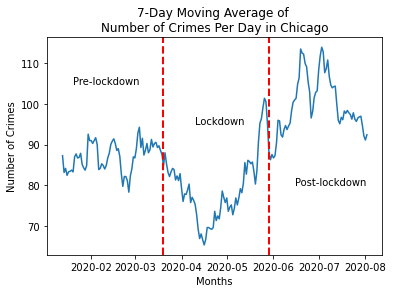

In [6]:
x = prepostct["Dates"]
y = prepostct["7day_ave"]
plt.plot(x,y)
plt.title("7-Day Moving Average of \nNumber of Crimes Per Day in Chicago")
plt.xlabel("Months")
plt.ylabel("Number of Crimes")
plt.axvline(pd.to_datetime('2020-03-20'), color='r', linestyle='--', lw=2)
plt.axvline(pd.to_datetime('2020-05-29'), color='r', linestyle='--', lw=2)
plt.text(pd.to_datetime("2020-01-20"), 105, "Pre-lockdown")
plt.text(pd.to_datetime("2020-04-10"), 95, "Lockdown")
plt.text(pd.to_datetime("2020-06-15"), 80, "Post-lockdown")
plt.savefig('Images/7dayavgnumcrimes.png', dpi = 350);

## A goodness of fit chi-square to evaluate whether number of crimes over three equal periods was the same

We ran a chi-square goodness of fit test because we were comparing counts of crimes from the three different periods. 

* $H_0$: There is no difference in levels of crime between the three equal periods (i.e., levels of crime did not rise or fall depending on the time period)

* $H_A$: During lockdown domestic crimes were higher than pre- or post-lockdown. 

* Finding: There is significant variation between the three periods (*p* < 0.001); however, the finding was in the opposite direction than hypothesized, where lockdown crime counts were the lowest compared to pre- and post-lockdown crime counts. 

In [27]:
observed = pd.Series([pre,lock,post], index=["Pre-lockdown", "Lockdown", "Post-Lockdown"])
df = pd.DataFrame([observed]).T
df[1] = (pre + lock + post)/3
df.columns = ["observed", "expected"]
pval = stats.chisquare(df['observed'], df['expected'])[1]
print(f'The p-value is: {pval}')

The p-value is: 1.8069899019433304e-30


## A heatmap of crime counts overall across Jan.-Aug. 2020 period

We found the counts of crimes per rounded latitude and longitude area and then used the counts as weights for the points and latitude/longitude rounded to 2 decimal places as the location. 

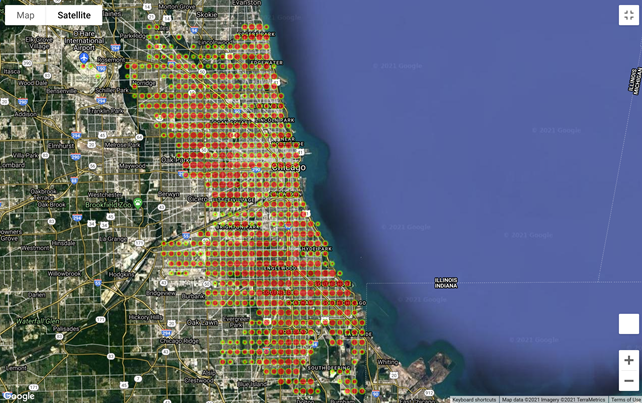

In [28]:
gmaps.configure(api_key=g_key)
pretopostdf = pretopostdf.dropna()
num = pretopostdf['id'].astype(float)
lat = pretopostdf['latitude'].astype(float)
lat = round(lat, 2)
long = pretopostdf['longitude'].astype(float)
long = round(long, 2)
data = zip(num, lat, long)
data = pd.DataFrame(data, columns = ['id', 'lat', 'long'])
locations = data.groupby(['lat', 'long']).count().reset_index().astype(float)[['lat', 'long']]
count = data.groupby(['lat', 'long']).count().reset_index().astype(float)['id']
fig = gmaps.figure(center=(41.9, -87.5),zoom_level=9.5, map_type = 'HYBRID')

heat_layer = gmaps.heatmap_layer(locations, weights=count, 
                                 dissipating=False, max_intensity=1,
                                 point_radius = 0.003)
fig.add_layer(heat_layer)
Image(filename='Images/chiheatmapzoomed.png')

## A bar graph of different categories of domestic crime committed during lockdown

We found the top four categories of crimes during lockdown and created a horizontal bar chart. This chart demonstrates that battery was the most common crime, followed by assault, other offenses, and offenses involving children. 

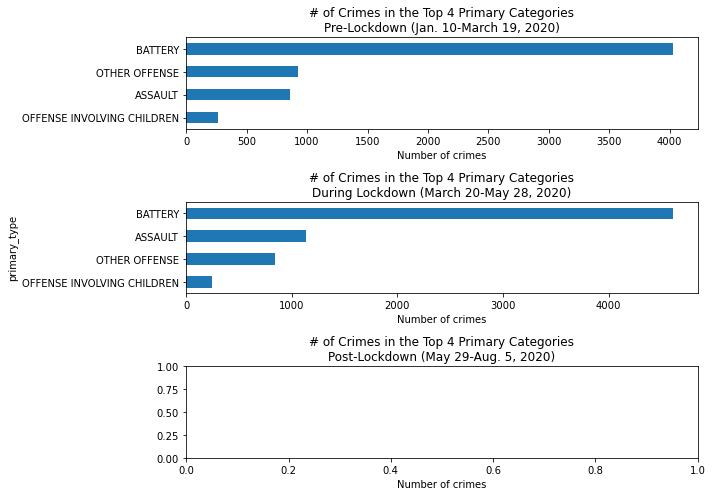

In [45]:
plt.figure(figsize=(10,7))
plt.ylabel("")

lktype = predf.groupby('primary_type').count().reset_index()
x2 = predf.groupby('primary_type')['id'].count().sort_values().tail(4)
plt.subplot(3, 1, 1)
x2.plot(kind = 'barh')
plt.title("# of Crimes in the Top 4 Primary Categories\nPre-Lockdown (Jan. 10-March 19, 2020)")
plt.xlabel("Number of crimes")
plt.ylabel("")

lktype = lockdowndf.groupby('primary_type').count().reset_index()
x1 = lockdowndf.groupby('primary_type')['id'].count().sort_values().tail(4)
plt.subplot(3, 1, 2)
x1.plot(kind = 'barh')
plt.title("# of Crimes in the Top 4 Primary Categories\nDuring Lockdown (March 20-May 28, 2020)")
plt.xlabel("Number of crimes")
plt.ylabel("")

lktype = postdf.groupby('primary_type').count().reset_index()
x3 = postdf.groupby('primary_type')['id'].count().sort_values().tail(4)
x3.plot(kind = 'barh')
plt.subplot(3, 1, 3)
plt.title("# of Crimes in the Top 4 Primary Categories\nPost-Lockdown (May 29-Aug. 5, 2020)")
plt.xlabel("Number of crimes")
plt.ylabel("")

plt.tight_layout()

plt.savefig("Images/crimes4catall.png", dpi = 350)
plt.show();

# Chicago Community Area Breakdown By Race/Ethnicity and Hardship

In [11]:
hardship = pd.read_csv("Data/hardship_index.csv")
race = pd.read_csv("Data/race_community.csv")
dfmerge = pd.merge(hardship, race, on = "GEOID")
dfmerge = dfmerge.iloc[1: , :]
x = dfmerge['HDX_2015-2019'].astype(float)
y = dfmerge['PCT-W_2015-2019'].astype(float)

Hardship and % White are nearly perfectly correlated, where neighborhoods that are predominately White have low hardship levels and vice versa.

In [12]:
pg.corr(x, y).round(3)

,n,r,CI95%,p-val,BF10,power
pearson,77,-0.909,"[-0.94, -0.86]",0.0,1.008e+27,1.0


# Domestic Violence Related PyTrends Key Terms Searches

In [13]:
startTime = time.time()
pytrend = TrendReq(hl='en-US', tz=360)

colnames = ["keywords"]
df = pd.read_csv("Data/search_terms.csv", names=colnames)
df2 = df["keywords"].values.tolist()
df2.remove("Keywords")

dataset = []

for x in range(0,len(df2)):
     keywords = [df2[x]]
     pytrend.build_payload(
     kw_list=keywords,
     cat=0,
     timeframe='2020-01-10 2020-08-05', # from and to dates here
     geo='US-IL') # 
     data = pytrend.interest_over_time()
     if not data.empty:
          data = data.drop(labels=['isPartial'],axis='columns')
          dataset.append(data)

df = pd.concat(dataset, axis=1)
df.to_csv('Data/trends.csv')
executionTime = (time.time() - startTime)
print('Execution time in sec.: ' + str(executionTime))
print(df)

Execution time in sec.: 2.7396671772003174
            domestic violence  domestic abuse  restraining order  \
date                                                               
2020-01-10                 28               0                 28   
2020-01-11                  0               0                  0   
2020-01-12                 16              36                  0   
2020-01-13                 40               0                  0   
2020-01-14                 13               0                  0   
...                       ...             ...                ...   
2020-08-01                 32               0                 32   
2020-08-02                 32               0                 32   
2020-08-03                 28              32                  0   
2020-08-04                 14               0                  0   
2020-08-05                 28               0                  0   

            order of protection  
date                             
2020

In [14]:
df = df.reset_index()
rangedf = df[(df['date'] >= '2020-01-10') & (df['date'] <= '2020-08-05')]
dfpre = rangedf[(rangedf['date'] >= '2020-01-10') & (rangedf['date'] <= '2020-03-19')]
dflockdown = rangedf[(rangedf['date'] >= '2020-03-20') & (rangedf['date'] <= '2020-05-28')]
dfpost = rangedf[(rangedf['date'] >= '2020-05-29') & (rangedf['date'] <= '2020-08-05')]

In [15]:
dfpre["group"] = 'Pre-lockdown'
dflockdown["group"] = 'Lockdown'
dfpost["group"] = 'Post-lockdown'
dfgroups = dfpre.iloc[:-1 , :].append(dflockdown).iloc[:-1 , :].append(dfpost).iloc[:-1 , :]
dfgroups['order of protection'] = dfgroups["order of protection"].astype(float)
dfgroups['domestic abuse'] = dfgroups['domestic abuse'].astype(float)
dfgroups['domestic violence'] = dfgroups['domestic violence'].astype(float)
dfgroups['restraining order'] = dfgroups['restraining order'].astype(float)
dfgroups.groupby('group').mean()

<ipython-input-15-f3c4dbf39e21>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfpre["group"] = 'Pre-lockdown'
<ipython-input-15-f3c4dbf39e21>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dflockdown["group"] = 'Lockdown'
<ipython-input-15-f3c4dbf39e21>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

,domestic violence,domestic abuse,restraining order,order of protection
group,,,,
Lockdown,28.318841,11.304348,11.971014,22.173913
Post-lockdown,24.000000,16.102941,9.573529,21.691176
Pre-lockdown,25.202899,13.507246,15.159420,25.144928


In [16]:
dfgroups.groupby('group').std()

,domestic violence,domestic abuse,restraining order,order of protection
group,,,,
Lockdown,21.503415,20.362382,19.759563,30.560911
Post-lockdown,19.363761,24.466328,16.026393,26.294121
Pre-lockdown,19.867635,18.584167,20.575273,27.962830


In [17]:
pg.welch_anova(dv='domestic violence', between='group', data=dfgroups).round(3)

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,135.149,0.791,0.455,0.008


In [18]:
pg.welch_anova(dv='restraining order', between='group', data=dfgroups).round(3)

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,133.851,1.571,0.212,0.015


In [19]:
pg.welch_anova(dv='domestic abuse', between='group', data=dfgroups).round(3)

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,133.487,0.777,0.462,0.009


In [20]:
pg.welch_anova(dv='order of protection', between='group', data=dfgroups).round(3)

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,134.963,0.311,0.733,0.003


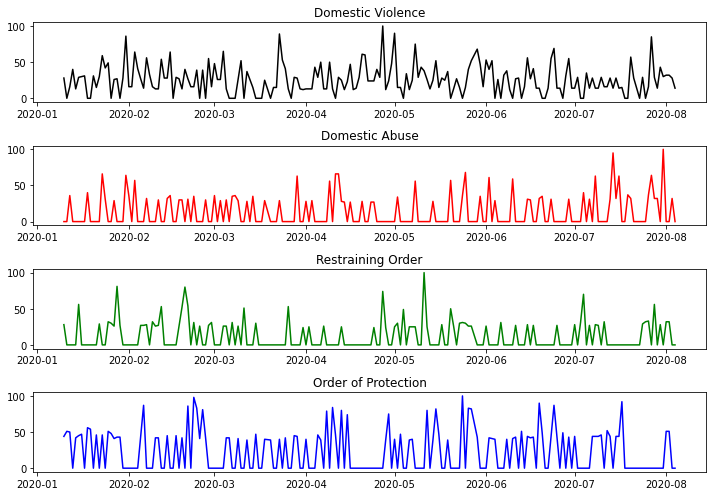

In [21]:
plt.figure(figsize=(10,7))

plt.subplot(4, 1, 1)
plt.plot(dfgroups['date'], dfgroups["domestic violence"],'black')
plt.title('Domestic Violence')

plt.subplot(4, 1, 2)
plt.plot(dfgroups['date'], dfgroups["domestic abuse"],'red')
plt.title('Domestic Abuse')

plt.subplot(4, 1, 3)
plt.plot(dfgroups['date'],dfgroups["restraining order"],'green')
plt.title('Restraining Order')

plt.subplot(4, 1, 4)
plt.plot(dfgroups['date'],dfgroups["order of protection"],'blue')
plt.title('Order of Protection')

plt.tight_layout()
plt.savefig("Images/rawsearchtermsgraph.png", dpi = 350)
plt.show();